In [1]:
# %pwd
import os
os.chdir("../")
%pwd

'/home/malik-harris/tekhqs/didenv/Decentralized_Identity_Verification'

In [2]:
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score, BinaryAUROC
from tqdm import tqdm
import matplotlib.pyplot as plt
import zipfile
import os
from PIL import Image
from torchvision import transforms
import random
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [3]:
torch.manual_seed(42)

In [4]:
zip_path = "data/Diddata.zip"
extract_to = "data"

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    members = zip_ref.namelist()
    for member in tqdm(members, desc="Extracting"):
        zip_ref.extract(member, extract_to)

print(f"Extracted to {extract_to}")

Extracting: 100%|██████████| 725/725 [00:07<00:00, 94.95it/s] 

Extracted to data


In [5]:
base_dir = "data/Diddata"
dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
dirs.sort()  # Sort for consistent numbering

for idx, dirname in enumerate(dirs, start=1):
    src = os.path.join(base_dir, dirname)
    dst = os.path.join(base_dir, str(idx))
    os.rename(src, dst)

print(f"Renamed {len(dirs)} directories to 1-{len(dirs)}")

Renamed 55 directories to 1-55


In [6]:
# Cell 2: Custom Dataset for KYC Verification (with positive and negative pairs)
class KYCVerificationDataset(Dataset):
    def __init__(self, root, transform=None, neg_ratio=1.0):
        self.transform = transform
        self.pairs = []
        self.labels = []
        self.person_dirs = [os.path.join(root, d) for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
        self.person_dirs.sort()
        # Collect all doc and selfie images for each person
        self.docs = []
        self.selfies = []
        for person_dir in self.person_dirs:
            doc_imgs = [os.path.join(person_dir, f) for f in os.listdir(person_dir) if 'id' in f.lower() or 'passport' in f.lower() or 'national' in f.lower()]
            selfie_imgs = [os.path.join(person_dir, f) for f in os.listdir(person_dir) if 'selfie' in f.lower()]
            self.docs.append(doc_imgs)
            self.selfies.append(selfie_imgs)
        # Positive pairs (same person)
        for i, (doc_list, selfie_list) in enumerate(zip(self.docs, self.selfies)):
            for doc in doc_list:
                for selfie in selfie_list:
                    self.pairs.append((doc, selfie))
                    self.labels.append(1)
        # Negative pairs (different people)
        num_neg = int(len(self.pairs) * neg_ratio)
        for _ in range(num_neg):
            i, j = random.sample(range(len(self.person_dirs)), 2)
            if self.docs[i] and self.selfies[j]:
                doc = random.choice(self.docs[i])
                selfie = random.choice(self.selfies[j])
                self.pairs.append((doc, selfie))
                self.labels.append(0)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        doc_path, selfie_path = self.pairs[idx]
        doc_img = Image.open(doc_path).convert("RGB")
        selfie_img = Image.open(selfie_path).convert("RGB")
        if self.transform:
            doc_img = self.transform(doc_img)
            selfie_img = self.transform(selfie_img)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return doc_img, selfie_img, label

In [7]:
# Cell 3: Siamese Network Definition
class LightweightCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), 

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), 

            nn.Conv2d(32, 64, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2), 

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  
        self.out_dim = 128  

    def forward(self, x):
        x = self.features(x)  
        x = self.avgpool(x) 
        x = torch.flatten(x, start_dim=1)
        return x 
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = LightweightCNN()
        self.project = nn.Linear(128, 512)
        self.fc = nn.Sequential(
            nn.Linear(512 * 2, 256),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(256, 1)
        )

    def forward(self, x1, x2):
        f1 = self.cnn(x1) 
        f1 = self.project(f1)  
        f2 = self.cnn(x2) 
        f2 = self.project(f2) 
        out = torch.cat([f1, f2], dim=1) 
        out = self.fc(out)
        return out.squeeze(1)


In [8]:
from sklearn.model_selection import train_test_split
# Cell 4: DataLoader and Training Setup
transform = transforms.Compose([
    transforms.Resize((112,112)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
dataset = KYCVerificationDataset(root="data/Diddata", transform=transform, neg_ratio=1.0)

all_indices = list(range(len(dataset)))
# First split: train+val vs test
trainval_indices, test_indices = train_test_split(all_indices, test_size=0.1, random_state=42, shuffle=True)
# Second split: train vs val
train_indices, val_indices = train_test_split(trainval_indices, test_size=0.1, random_state=42, shuffle=True)

from torch.utils.data import Subset, DataLoader

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = SiameseNetwork().to(device)
# model.load_state_dict(torch.load("/kaggle/input/best_syamese_model.pt/pytorch/default/2/best_kyc_siamese.pt", map_location=device))
# print("✅ Loaded model weights from best_kyc_siamese.pt")
criterion = nn.BCEWithLogitsLoss()
# criterion = ContrastiveLoss()  # costom loss
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

Using device: cuda


In [10]:
# Initialize lists before the training loop
# train_losses, val_losses = [], []
# train_accs, val_accs = [], []
# train_f1s, val_f1s = [], []
# train_aucs, val_aucs = [], []
# epochs = 50
# best_val_auc = 0.0

# for epoch in range(epochs):  
#     # --- Training ---
#     model.train()
#     running_loss = 0.0
#     acc_metric = BinaryAccuracy().to(device)
#     prec_metric = BinaryPrecision().to(device)
#     rec_metric = BinaryRecall().to(device)
#     f1_metric = BinaryF1Score().to(device)
#     auc_metric = BinaryAUROC().to(device)

#     for doc_img, selfie_img, label in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
#         doc_img, selfie_img, label = doc_img.to(device), selfie_img.to(device), label.to(device)
#         optimizer.zero_grad()
#         output = model(doc_img, selfie_img)
#         loss = criterion(output, label)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()

#         probs = torch.sigmoid(output)
#         preds = (probs > 0.5).float()
#         acc_metric.update(preds, label)
#         prec_metric.update(preds, label)
#         rec_metric.update(preds, label)
#         f1_metric.update(preds, label)
#         auc_metric.update(probs, label)

#     train_acc = acc_metric.compute().item()
#     train_prec = prec_metric.compute().item()
#     train_rec = rec_metric.compute().item()
#     train_f1 = f1_metric.compute().item()
#     train_auc = auc_metric.compute().item()
#     avg_train_loss = running_loss / len(train_loader)
#     print(f"Train Epoch {epoch+1}: Loss={avg_train_loss:.4f}, Acc={train_acc:.4f}, Prec={train_prec:.4f}, Rec={train_rec:.4f}, F1={train_f1:.4f}, AUC={train_auc:.4f}")

#     # --- Validation ---
#     model.eval()
#     val_loss = 0.0
#     val_acc_metric = BinaryAccuracy().to(device)
#     val_prec_metric = BinaryPrecision().to(device)
#     val_rec_metric = BinaryRecall().to(device)
#     val_f1_metric = BinaryF1Score().to(device)
#     val_auc_metric = BinaryAUROC().to(device)
#     with torch.no_grad():
#         for doc_img, selfie_img, label in val_loader:
#             doc_img, selfie_img, label = doc_img.to(device), selfie_img.to(device), label.to(device)
#             output = model(doc_img, selfie_img)
#             loss = criterion(output, label)
#             val_loss += loss.item()

#             probs = torch.sigmoid(output)
#             preds = (probs > 0.5).float()
#             val_acc_metric.update(preds, label)
#             val_prec_metric.update(preds, label)
#             val_rec_metric.update(preds, label)
#             val_f1_metric.update(preds, label)
#             val_auc_metric.update(probs, label)

#     val_acc = val_acc_metric.compute().item()
#     val_prec = val_prec_metric.compute().item()
#     val_rec = val_rec_metric.compute().item()
#     val_f1 = val_f1_metric.compute().item()
#     val_auc = val_auc_metric.compute().item()
#     avg_val_loss = val_loss / len(val_loader)
#     print(f"Val Epoch {epoch+1}: Loss={avg_val_loss:.4f}, Acc={val_acc:.4f}, Prec={val_prec:.4f}, Rec={val_rec:.4f}, F1={val_f1:.4f}, AUC={val_auc:.4f}")

#     # Save best model by validation AUC
#     if val_auc > best_val_auc:
#         best_val_auc = val_auc
#         torch.save(model.state_dict(), "best_kyc_siamese.pt")
#         print(f"✅ Best model saved at epoch {epoch+1} with Val AUC={val_auc:.4f}")

#     # ---- APPEND METRICS HERE ----
#     train_losses.append(avg_train_loss)
#     val_losses.append(avg_val_loss)
#     train_accs.append(train_acc)
#     val_accs.append(val_acc)
#     train_f1s.append(train_f1)
#     val_f1s.append(val_f1)
#     train_aucs.append(train_auc)
#     val_aucs.append(val_auc)

# # Plotting
# epochs_range = range(1, epochs+1)
# plt.figure(figsize=(20,5))

# plt.subplot(1,4,1)
# plt.plot(epochs_range, train_losses, label='Train Loss')
# plt.plot(epochs_range, val_losses, label='Val Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Loss')

# plt.subplot(1,4,2)
# plt.plot(epochs_range, train_accs, label='Train Acc')
# plt.plot(epochs_range, val_accs, label='Val Acc')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Accuracy')

# plt.subplot(1,4,3)
# plt.plot(epochs_range, train_f1s, label='Train F1')
# plt.plot(epochs_range, val_f1s, label='Val F1')
# plt.xlabel('Epoch')
# plt.ylabel('F1 Score')
# plt.legend()
# plt.title('F1 Score')

# plt.subplot(1,4,4)
# plt.plot(epochs_range, train_aucs, label='Train AUC')
# plt.plot(epochs_range, val_aucs, label='Val AUC')
# plt.xlabel('Epoch')
# plt.ylabel('ROC AUC')
# plt.legend()
# plt.title('ROC AUC')

# plt.tight_layout()
# os.makedirs("plot", exist_ok=True)
# plt.savefig("plot/training_validation_metrics.png", dpi=300)

# # Now show it
# plt.show()

Testing: 100%|██████████| 9/9 [00:21<00:00,  2.36s/it]


Best Model Test Results: Loss=0.4773, Acc=0.8310, Prec=0.8365, Rec=0.9255, F1=0.8788, AUC=0.8223


<Figure size 500x500 with 0 Axes>

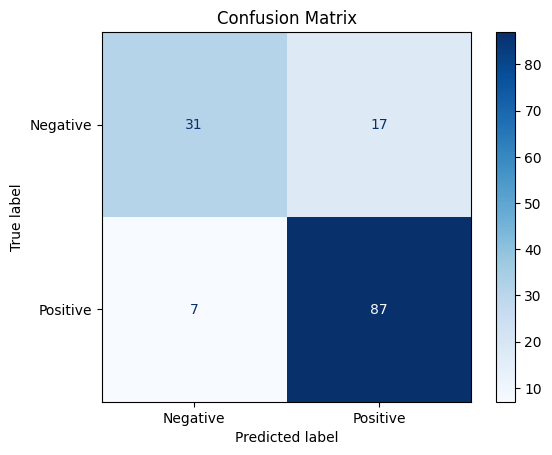

              precision    recall  f1-score   support

    Negative       0.82      0.65      0.72        48
    Positive       0.84      0.93      0.88        94

    accuracy                           0.83       142
   macro avg       0.83      0.79      0.80       142
weighted avg       0.83      0.83      0.83       142



In [11]:

# --- Test Set Evaluation with Confusion Matrix and Classification Report ---

# Load the best model
model.load_state_dict(torch.load("Model/best_kyc_siamese.pt"))
model.eval()

all_labels = []
all_preds = []
test_loss = 0.0

test_acc_metric = BinaryAccuracy().to(device)
test_prec_metric = BinaryPrecision().to(device)
test_rec_metric = BinaryRecall().to(device)
test_f1_metric = BinaryF1Score().to(device)
test_auc_metric = BinaryAUROC().to(device)

with torch.no_grad():
    for doc_img, selfie_img, label in tqdm(test_loader, desc="Testing"):
        doc_img, selfie_img, label = doc_img.to(device), selfie_img.to(device), label.to(device)
        output = model(doc_img, selfie_img)
        loss = criterion(output, label)
        test_loss += loss.item()
        probs = torch.sigmoid(output)
        preds = (probs > 0.5).float()
        all_labels.extend(label.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        test_acc_metric.update(preds, label)
        test_prec_metric.update(preds, label)
        test_rec_metric.update(preds, label)
        test_f1_metric.update(preds, label)
        test_auc_metric.update(probs, label)


avg_test_loss = test_loss / len(test_loader)
test_acc = test_acc_metric.compute().item()
test_prec = test_prec_metric.compute().item()
test_rec = test_rec_metric.compute().item()
test_f1 = test_f1_metric.compute().item()
test_auc = test_auc_metric.compute().item()


print(f"Best Model Test Results: Loss={avg_test_loss:.4f}, Acc={test_acc:.4f}, Prec={test_prec:.4f}, Rec={test_rec:.4f}, F1={test_f1:.4f}, AUC={test_auc:.4f}")
# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
os.makedirs("plot", exist_ok=True)
plt.figure(figsize=(5,5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.savefig("plot/confusion_matrix.png")
plt.show()

# --- Classification Report ---
report = classification_report(all_labels, all_preds, target_names=["Negative", "Positive"])
print(report)
with open("plot/classification_report.txt", "w") as f:
    f.write(report)

# --- Save best stats to a file ---
with open("plot/best_model_stats.txt", "w") as f:
    f.write(f"Best Model Test Results:\n")
    f.write(f"Loss: {avg_test_loss:.4f}\n")
    f.write(f"Accuracy: {test_acc:.4f}\n")
    f.write(f"Precision: {test_prec:.4f}\n")
    f.write(f"Recall: {test_rec:.4f}\n")
    f.write(f"F1 Score: {test_f1:.4f}\n")
    f.write(f"ROC AUC: {test_auc:.4f}\n")